In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import nltk
import pickle
import keras

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, InputLayer, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPool1D, Embedding, GRU
from tensorflow.keras.callbacks import EarlyStopping

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# names = pd.read_csv('data/key.csv', sep='\t').columns.tolist()
# df = pd.read_csv('data/train-balanced.csv', sep='\t', header=None, names=names, usecols=['comment', 'label'])
# df.dropna(inplace=True)
# df.head()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

In [5]:
df = pd.read_csv(root+'train_data.csv')
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [6]:
X_train, y_train = df['comment'], df['label']

In [ ]:
# X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.9)

In [18]:
X_train.shape

(1010773,)

In [72]:
def plot_history(fit):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    for i, which in enumerate(['accuracy', 'loss']):
        ax = axes[i]
        ax.plot(fit.history[which], label=which);
        ax.plot(fit.history['val_'+which], label='val_'+which);
        ax.set_xlabel('epoch');
        ax.set_ylabel(which);
        ax.legend();

# bag of words

In [ ]:
all_sw = list(sklear_stopwords) + stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words=all_sw, ngram_range=(1,1))
X_train = count_vectorizer.fit_transform(X_train)

In [ ]:
len(count_vectorizer.get_feature_names_out())

48984

In [ ]:
mutual_info = SelectKBest(mutual_info_classif, k=5000)
X_train_mi = mutual_info.fit_transform(X_train, y_train)

In [ ]:
with open(root+'X_train_mi', 'wb') as x:
    pickle.dump(X_train_mi, x)

with open(root+'y_train_mi', 'wb') as x:
    pickle.dump(y_train, x)

In [ ]:
X_train_mi = pickle.load(open(root+'X_train_mi','rb'))
y_train_mi = pickle.load(open(root+'y_train_mi','rb'))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_mi, y_train_mi, stratify=y_train_mi, test_size=0.2)

In [ ]:
X_train.shape, X_val.shape

((80861, 5000), (20216, 5000))

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train);

In [ ]:
y_pred = mnb.predict(X_val)

print(confusion_matrix(y_pred, y_val))
print('accuracy:', accuracy_score(y_pred, y_val).round(3))

[[7455 3740]
 [2653 6368]]
accuracy: 0.684


In [ ]:
def sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_train), y_train)).shuffle(100).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((sparse_tensor(X_val), y_val)).batch(256)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(1000, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3159/3159 [==============================] - 244s 77ms/step - loss: 0.6265 - accuracy: 0.6542 - val_loss: 0.6112 - val_accuracy: 0.6654
Epoch 2/50
3159/3159 [==============================] - 242s 76ms/step - loss: 0.6008 - accuracy: 0.6732 - val_loss: 0.6111 - val_accuracy: 0.6635
Epoch 3/50
3159/3159 [==============================] - 241s 76ms/step - loss: 0.5869 - accuracy: 0.6847 - val_loss: 0.6131 - val_accuracy: 0.6593
Epoch 4/50
3159/3159 [==============================] - 239s 76ms/step - loss: 0.5742 - accuracy: 0.6946 - val_loss: 0.6142 - val_accuracy: 0.6604


In [ ]:
X_train, X_val = X_train.toarray(), X_val.toarray()

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(200, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(200, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=64, epochs=100, callbacks=[es])

Epoch 1/100
1258/1264 [============================>.] - ETA: 0s - loss: 0.6568 - accuracy: 0.6334

# rnn

## non-pretrained embeddings

In [20]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [21]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
input_dim = len(tokenizer.word_index) + 1

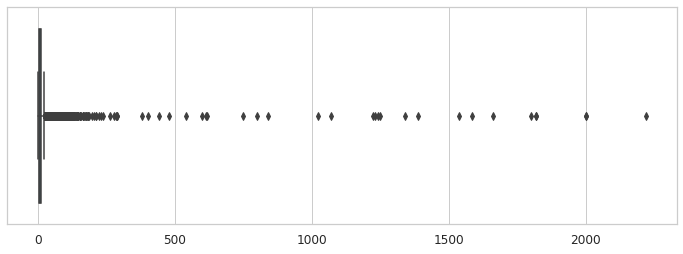

In [22]:
sen_len = [len(i) for i in X_train_tok]

plt.figure(figsize=(12,4))
sns.boxplot(x=sen_len);

In [23]:
np.quantile(sen_len, 0.9)

19.0

In [24]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=20)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, y_train, stratify=y_train, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

In [27]:
X_train.shape, X_val.shape, X_test.shape

((727756, 20), (202155, 20), (80862, 20))

In [28]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [29]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=20, mask_zero=True),
    GRU(100, dropout=0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 710s 124ms/step - loss: 0.5720 - accuracy: 0.6987 - val_loss: 0.5545 - val_accuracy: 0.7141
Epoch 2/50
5686/5686 [==============================] - 665s 117ms/step - loss: 0.5436 - accuracy: 0.7221 - val_loss: 0.5469 - val_accuracy: 0.7184
Epoch 3/50
5686/5686 [==============================] - 668s 117ms/step - loss: 0.5279 - accuracy: 0.7324 - val_loss: 0.5464 - val_accuracy: 0.7199
Epoch 4/50
5686/5686 [==============================] - 673s 118ms/step - loss: 0.5147 - accuracy: 0.7424 - val_loss: 0.5495 - val_accuracy: 0.7208
Epoch 5/50
5686/5686 [==============================] - 670s 118ms/step - loss: 0.5019 - accuracy: 0.7508 - val_loss: 0.5511 - val_accuracy: 0.7179
Epoch 6/50
5686/5686 [==============================] - 666s 117ms/step - loss: 0.4902 - accuracy: 0.7592 - val_loss: 0.5560 - val_accuracy: 0.7173


In [30]:
model.evaluate(X_val, y_val)

6318/6318 [==============================] - 47s 7ms/step - loss: 0.5464 - accuracy: 0.7199


[0.5464373230934143, 0.7198931574821472]

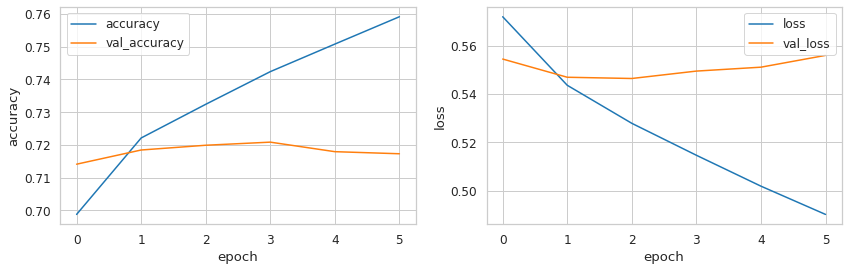

In [31]:
plot_history(fit)

In [57]:
y_pred = model.predict(X_val).round().flatten()

In [59]:
confusion = confusion_matrix(y_val, y_pred, normalize='true')

In [60]:
accuracy_score(y_val, y_pred)

0.7198931512947986

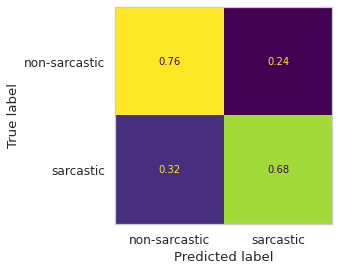

In [61]:
matrix_display = ConfusionMatrixDisplay(confusion, display_labels=['non-sarcastic', 'sarcastic'])
matrix_display.plot(colorbar=False)
plt.grid(False);

In [32]:
model.save(root+'gru')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets


## pretrained embeddings: non-trainable

In [62]:
vec_len = 100

In [69]:
glove_words = []

In [70]:
embedding_matrix = np.zeros((input_dim, vec_len))

with open(root+'glove.6B.'+str(vec_len)+'d.txt') as file:
# with open(root+'glove.twitter.27B.50d.txt') as file:
    for line in file:
        word, *vector = line.split()
        glove_words.append(word)
        if word in tokenizer.word_index:
            embedding_matrix[tokenizer.word_index[word]] = np.array(vector, dtype=np.float32)

In [66]:
round(np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))/input_dim, 4)

0.4739

In [72]:
not_covered_words = []

In [73]:
for word in tokenizer.word_index:
    if word not in glove_words:
        not_covered_words.append(word)

In [75]:
not_covered_words[:50]

["it's",
 "don't",
 "i'm",
 "that's",
 "you're",
 "can't",
 "didn't",
 "he's",
 "doesn't",
 "isn't",
 "they're",
 "i've",
 "there's",
 "i'd",
 "wouldn't",
 "aren't",
 "i'll",
 "wasn't",
 "won't",
 "we're",
 "she's",
 "what's",
 "let's",
 "haven't",
 "shouldn't",
 "couldn't",
 "you'll",
 "you've",
 "they'll",
 "you'd",
 'subreddit',
 "weren't",
 "we'll",
 "hasn't",
 "it'll",
 'shitlord',
 "who's",
 'amirite',
 "they've",
 "he'll",
 'lmao',
 "we've",
 'downvoted',
 'downvote',
 'idk',
 "they'd",
 'upvote',
 "should've",
 "ain't",
 "would've"]

In [1]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=20, mask_zero=True,
              weights=[embedding_matrix], trainable=False),
    GRU(100, return_sequences=True),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

NameError: ignored

In [7]:
slang = pd.read_csv(root+'slang.csv')

In [21]:
slang_mapping = dict(list(slang[['acronym', 'expansion']].to_records(index=False)))

In [22]:
!pip install contractions

     |████████████████████████████████| 321 kB 5.4 MB/s 
     |████████████████████████████████| 284 kB 60.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=50bae8c5ebb4a55d6ca6946feaec80e942223def8641c379f9d3a7d3b2c7f2c9
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [23]:
import contractions
contractions.fix("you're happy now")

'you are happy now'

In [27]:
X = df['comment'].replace(slang_mapping).apply(lambda x: contractions.fix(x))

In [28]:
y = df['label']

In [29]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [30]:
X_train_tok = tokenizer.texts_to_sequences(X)
input_dim = len(tokenizer.word_index) + 1

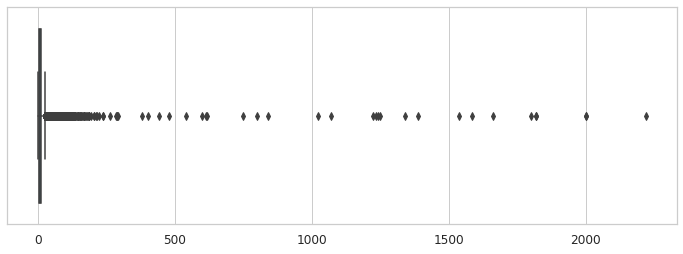

In [31]:
sen_len = [len(i) for i in X_train_tok]

plt.figure(figsize=(12,4))
sns.boxplot(x=sen_len);

In [32]:
np.quantile(sen_len, 0.9)

20.0

In [33]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=20)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, y_train, stratify=y_train, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

In [35]:
X_train.shape, X_val.shape, X_test.shape

((727756, 20), (202155, 20), (80862, 20))

In [60]:
input_dim = 10000

In [61]:
vec_len = 100

In [65]:
glove_words = []

In [66]:
embedding_matrix = np.zeros((input_dim, vec_len))

with open(root+'glove.6B.'+str(vec_len)+'d.txt') as file:
# with open(root+'glove.twitter.27B.50d.txt') as file:
    for line in file:
        word, *vector = line.split()
        glove_words.append(word)
        if word in tokenizer.word_index:
            if tokenizer.word_index[word] < 10000:
                embedding_matrix[tokenizer.word_index[word]] = np.array(vector, dtype=np.float32)

In [67]:
round(np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))/input_dim, 4)

0.9757

In [41]:
not_covered_words = []

In [42]:
for word in tokenizer.word_index:
    if word not in glove_words:
        not_covered_words.append(word)

In [45]:
not_covered_words[:20]

['subreddit',
 'shitlord',
 'amirite',
 'downvoted',
 'downvote',
 'lmao',
 'idk',
 'upvote',
 'tbh',
 "people's",
 'hahaha',
 'ayy',
 'inb4',
 'downvotes',
 'circlejerk',
 'upvotes',
 "op's",
 'nsfw',
 'redditors',
 'tronald']

In [46]:
len(tokenizer.word_index.keys())

180325

In [52]:
not_covered_words[-5:]

['provedes', 'konspiracy', 'p42dc', 'barackobama', 'aghaghagh']

In [68]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [69]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=20, mask_zero=True,
              weights=[embedding_matrix], trainable=False),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 383s 66ms/step - loss: 0.6216 - accuracy: 0.6473 - val_loss: 0.5884 - val_accuracy: 0.6822
Epoch 2/50
5686/5686 [==============================] - 376s 66ms/step - loss: 0.5935 - accuracy: 0.6775 - val_loss: 0.5743 - val_accuracy: 0.6958
Epoch 3/50
5686/5686 [==============================] - 374s 66ms/step - loss: 0.5845 - accuracy: 0.6859 - val_loss: 0.5677 - val_accuracy: 0.7000
Epoch 4/50
5686/5686 [==============================] - 378s 66ms/step - loss: 0.5793 - accuracy: 0.6905 - val_loss: 0.5647 - val_accuracy: 0.7038
Epoch 5/50
5686/5686 [==============================] - 375s 66ms/step - loss: 0.5759 - accuracy: 0.6937 - val_loss: 0.5674 - val_accuracy: 0.7004
Epoch 6/50
5686/5686 [==============================] - 377s 66ms/step - loss: 0.5732 - accuracy: 0.6962 - val_loss: 0.5599 - val_accuracy: 0.7080
Epoch 7/50
5686/5686 [==============================] - 381s 67ms/step - loss: 0.5718 - accuracy: 0.6973 - val_loss: 0

In [70]:
model.evaluate(X_val, y_val)

6318/6318 [==============================] - 49s 8ms/step - loss: 0.5582 - accuracy: 0.7097


[0.5582489967346191, 0.7096683382987976]

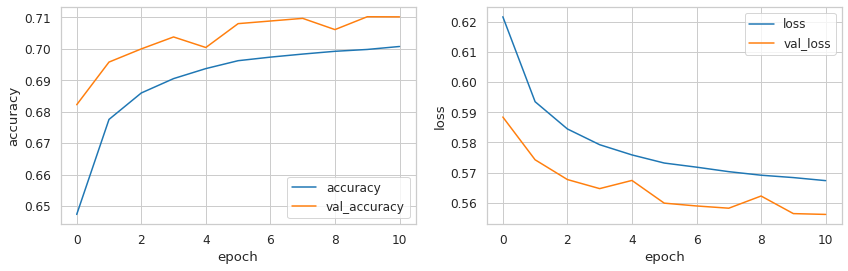

In [73]:
plot_history(fit)

In [74]:
y_pred = model.predict(X_val).round().flatten()

In [75]:
confusion = confusion_matrix(y_val, y_pred, normalize='true')

In [76]:
accuracy_score(y_val, y_pred)

0.7096683238109371

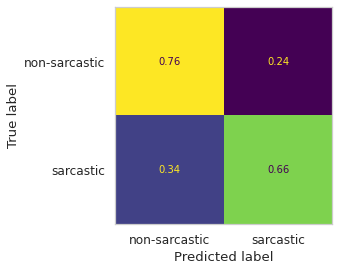

In [77]:
matrix_display = ConfusionMatrixDisplay(confusion, display_labels=['non-sarcastic', 'sarcastic'])
matrix_display.plot(colorbar=False)
plt.grid(False);

## pretrained embeddings: trainable

In [78]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=20, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 478s 83ms/step - loss: 0.5848 - accuracy: 0.6856 - val_loss: 0.5572 - val_accuracy: 0.7110
Epoch 2/50
5686/5686 [==============================] - 471s 83ms/step - loss: 0.5519 - accuracy: 0.7156 - val_loss: 0.5468 - val_accuracy: 0.7185
Epoch 3/50
5686/5686 [==============================] - 472s 83ms/step - loss: 0.5393 - accuracy: 0.7248 - val_loss: 0.5418 - val_accuracy: 0.7226
Epoch 4/50
5686/5686 [==============================] - 475s 83ms/step - loss: 0.5303 - accuracy: 0.7311 - val_loss: 0.5400 - val_accuracy: 0.7247
Epoch 5/50
5686/5686 [==============================] - 472s 83ms/step - loss: 0.5229 - accuracy: 0.7368 - val_loss: 0.5393 - val_accuracy: 0.7255
Epoch 6/50
5686/5686 [==============================] - 475s 84ms/step - loss: 0.5166 - accuracy: 0.7421 - val_loss: 0.5412 - val_accuracy: 0.7260
Epoch 7/50
5686/5686 [==============================] - 474s 83ms/step - loss: 0.5109 - accuracy: 0.7455 - val_loss: 0

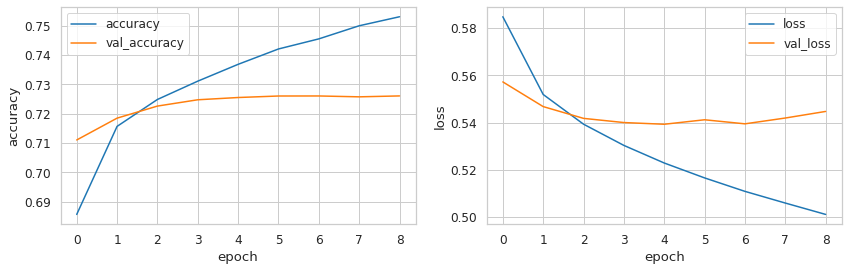

In [79]:
plot_history(fit)

In [80]:
y_pred = model.predict(X_val).round().flatten()

In [81]:
confusion = confusion_matrix(y_val, y_pred, normalize='true')

In [82]:
accuracy_score(y_val, y_pred)

0.7260221117459376

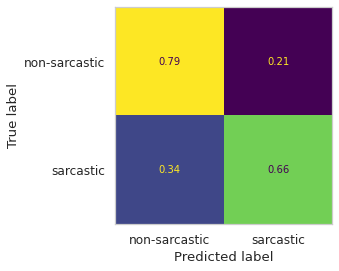

In [83]:
matrix_display = ConfusionMatrixDisplay(confusion, display_labels=['non-sarcastic', 'sarcastic'])
matrix_display.plot(colorbar=False)
plt.grid(False);

In [85]:
y_pred = model.predict(X_test).round().flatten()

In [86]:
confusion = confusion_matrix(y_test, y_pred, normalize='true')

In [88]:
accuracy_score(y_test, y_pred)

0.726002324948678

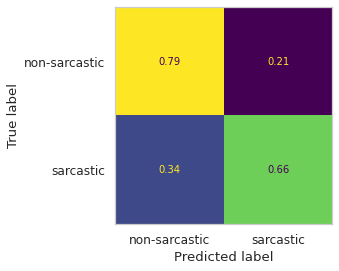

In [89]:
matrix_display = ConfusionMatrixDisplay(confusion, display_labels=['non-sarcastic', 'sarcastic'])
matrix_display.plot(colorbar=False)
plt.grid(False);

In [84]:
model.save(root+'gru_glove100_trainable')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_trainable/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru_glove100_trainable/assets


## non-pretrained: vol2 (preprocessing + smaller matrix)

In [90]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [91]:
X_train_tok = tokenizer.texts_to_sequences(X)
input_dim = 10000

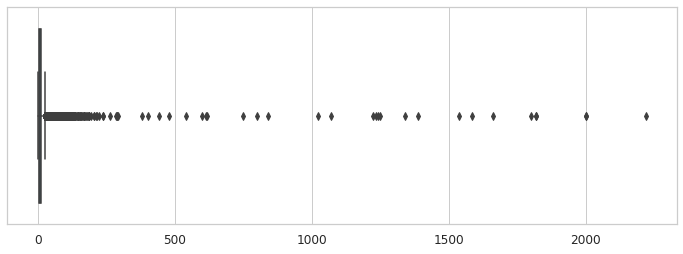

In [92]:
sen_len = [len(i) for i in X_train_tok]

plt.figure(figsize=(12,4))
sns.boxplot(x=sen_len);

In [93]:
np.quantile(sen_len, 0.9)

20.0

In [94]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=20)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, y, stratify=y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

In [97]:
X_train.shape, X_val.shape, X_test.shape

((727756, 20), (202155, 20), (80862, 20))

In [98]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [99]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=100, input_length=20, mask_zero=True),
    GRU(100, dropout=0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 482s 84ms/step - loss: 0.5756 - accuracy: 0.6959 - val_loss: 0.5576 - val_accuracy: 0.7097
Epoch 2/50
5686/5686 [==============================] - 464s 82ms/step - loss: 0.5480 - accuracy: 0.7186 - val_loss: 0.5498 - val_accuracy: 0.7151
Epoch 3/50
5686/5686 [==============================] - 470s 83ms/step - loss: 0.5333 - accuracy: 0.7297 - val_loss: 0.5485 - val_accuracy: 0.7171
Epoch 4/50
5686/5686 [==============================] - 469s 82ms/step - loss: 0.5216 - accuracy: 0.7381 - val_loss: 0.5471 - val_accuracy: 0.7195
Epoch 5/50
5686/5686 [==============================] - 469s 83ms/step - loss: 0.5109 - accuracy: 0.7454 - val_loss: 0.5501 - val_accuracy: 0.7178
Epoch 6/50
5686/5686 [==============================] - 470s 83ms/step - loss: 0.5018 - accuracy: 0.7523 - val_loss: 0.5517 - val_accuracy: 0.7172
Epoch 7/50
5686/5686 [==============================] - 471s 83ms/step - loss: 0.4937 - accuracy: 0.7576 - val_loss: 0

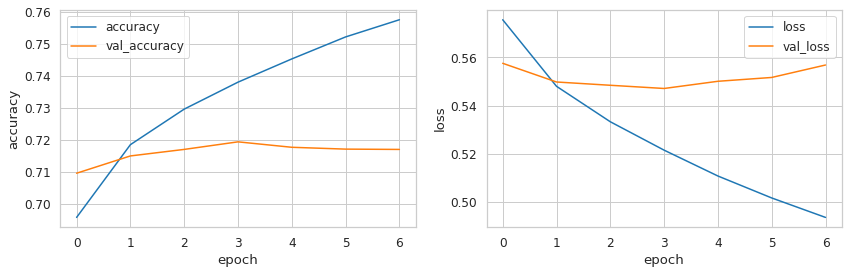

In [100]:
plot_history(fit)

In [101]:
y_pred = model.predict(X_val).round().flatten()

In [102]:
confusion = confusion_matrix(y_val, y_pred, normalize='true')

In [103]:
accuracy_score(y_val, y_pred)

0.7195023620489228

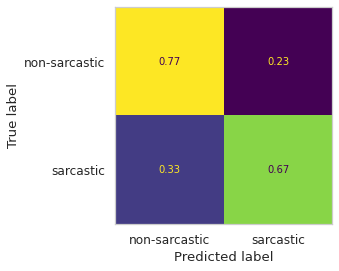

In [104]:
matrix_display = ConfusionMatrixDisplay(confusion, display_labels=['non-sarcastic', 'sarcastic'])
matrix_display.plot(colorbar=False)
plt.grid(False);

In [105]:
model.save(root+'gru')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/gru/assets
